In [1]:
import pandas as pd
from bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model, evaluate_model
from data_preparation.movielens_100k import MovieLens100KData
from recommender.factorization_recommender import fit_recommendation_model, retrain_recommendation_model,\
tune_recommendation_hyperparams

### Prepare training data

In [2]:
data = MovieLens100KData(data_path='data/ml-100k')
X_train, X_val, X_test = data.get_data_splits_for_training()

### Train MF recommendation model

In [3]:
EMBEDDING_SIZE = 10
NUM_EPOCH = 50
REGULARIZATION = 1e-4
LEARNING_RATE = 1e-3

In [ ]:
model = tune_recommendation_hyperparams(X_train, X_val, num_users=data.num_users, num_items=data.num_items, 
                                 epochs=NUM_EPOCH,)

Trial 1 Complete [00h 00m 08s]
val_loss: 101.82553100585938

Best val_loss So Far: 101.82553100585938
Total elapsed time: 00h 00m 08s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
embedding_size    |48                |48                
regularization_...|0.01              |0.0001            
learning_rate     |0.0001            |0.01              

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.exper

### Analyze bias for the recommendation model

In [ ]:
MIN_CHILD_NODE_SIZE = 1000
METRIC = 'squared_error'

In [ ]:
bias_tree_test = get_metric_bias_tree_for_model(model, X_test, data.attributes_dict, 
                                                 metric_name=METRIC,
                                                min_child_node_size=MIN_CHILD_NODE_SIZE)
display(bias_tree_test.leaf_metrics)

Show the node with highest error

In [ ]:
print(bias_tree_test.max_metric_node, round(bias_tree_test.max_metric_value, 3))

### Retrain the model for the biased nodes

{"gender": ["F"], "age_bucketized": ["high", "medium"]} 0.9844221133240428
Train on 10459 samples, validate on 3475 samples
Epoch 1/100
10459/10459 [==============================] - 0s 31us/sample - loss: 0.8575 - val_loss: 0.9582
Epoch 2/100
10459/10459 [==============================] - 0s 31us/sample - loss: 0.8500 - val_loss: 0.9570
Epoch 3/100
10459/10459 [==============================] - 0s 41us/sample - loss: 0.8433 - val_loss: 0.9560
Epoch 4/100
10459/10459 [==============================] - 0s 41us/sample - loss: 0.8371 - val_loss: 0.9556
Epoch 5/100
10459/10459 [==============================] - 0s 34us/sample - loss: 0.8321 - val_loss: 0.9554
Epoch 6/100
10459/10459 [==============================] - 0s 39us/sample - loss: 0.8287 - val_loss: 0.9551
Epoch 7/100
10459/10459 [==============================] - 0s 34us/sample - loss: 0.8251 - val_loss: 0.9554
Epoch 8/100
10459/10459 [==============================] - 0s 37us/sample - loss: 0.8205 - val_loss: 0.9556


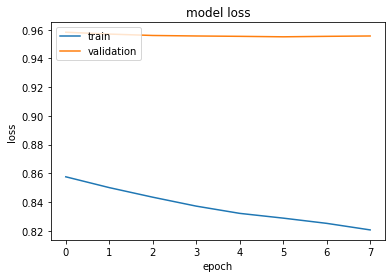

{"gender": ["M"], "year_bucketized": ["high"], "user activity_bucketized": ["low"]} 1.099102261584876
Train on 4491 samples, validate on 1492 samples
Epoch 1/100
4491/4491 [==============================] - 0s 41us/sample - loss: 0.9386 - val_loss: 1.1109
Epoch 2/100
4491/4491 [==============================] - 0s 36us/sample - loss: 0.9246 - val_loss: 1.1084
Epoch 3/100
4491/4491 [==============================] - 0s 38us/sample - loss: 0.9131 - val_loss: 1.1074
Epoch 4/100
4491/4491 [==============================] - 0s 35us/sample - loss: 0.9073 - val_loss: 1.1070
Epoch 5/100
4491/4491 [==============================] - 0s 32us/sample - loss: 0.8974 - val_loss: 1.1077
Epoch 6/100
4491/4491 [==============================] - 0s 34us/sample - loss: 0.8903 - val_loss: 1.1074


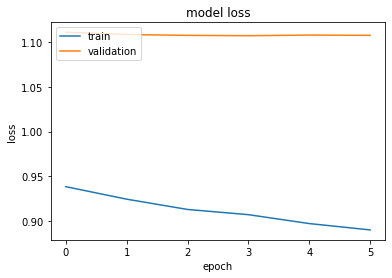

{"gender": ["F"], "age_bucketized": ["low"]} 1.1745345288447375
Train on 5004 samples, validate on 1699 samples
Epoch 1/100
5004/5004 [==============================] - 0s 36us/sample - loss: 1.0605 - val_loss: 1.0965
Epoch 2/100
5004/5004 [==============================] - 0s 30us/sample - loss: 1.0488 - val_loss: 1.0958
Epoch 3/100
5004/5004 [==============================] - 0s 36us/sample - loss: 1.0389 - val_loss: 1.0956
Epoch 4/100
5004/5004 [==============================] - 0s 55us/sample - loss: 1.0305 - val_loss: 1.0952
Epoch 5/100
5004/5004 [==============================] - 0s 60us/sample - loss: 1.0258 - val_loss: 1.0941
Epoch 6/100
5004/5004 [==============================] - 0s 40us/sample - loss: 1.0164 - val_loss: 1.0941
Epoch 7/100
5004/5004 [==============================] - 0s 60us/sample - loss: 1.0113 - val_loss: 1.0940
Epoch 8/100
5004/5004 [==============================] - 0s 49us/sample - loss: 1.0035 - val_loss: 1.0939
Epoch 9/100
5004/5004 [=================

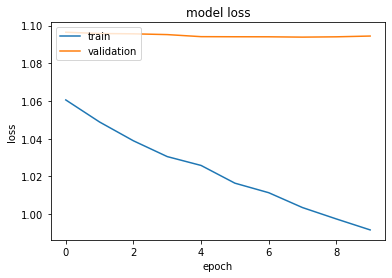

In [8]:
RETRAIN_EPOCHS = 100
mean_test_metric = X_test[METRIC].mean()
retrain_metrics = []

biased_nodes = bias_tree_test.leaf_metrics[bias_tree_test.leaf_metrics['mean'] > mean_test_metric]
for i, node_rules in biased_nodes.iterrows():
    print(node_rules.name,  node_rules["mean"])

    X_train_filtered = bias_tree_test.get_filtered_df(node_rules.name,  X_train)
    X_val_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_val)
    model_tuned_bias = tune_recommendation_hyperparams(X_train, X_val_filtered, num_users=data.num_users,
                                                       num_items=data.num_items, 
                                 epochs=NUM_EPOCH,)
#     model = fit_recommendation_model(X_train, X_val_filtered, num_users=data.num_users, num_items=data.num_items, 
#                                  epochs=100, embedding_size=10, 
#                                  regularization_coef=1e-4,
#                                  lr=0.001)
    model_bias = retrain_recommendation_model(X_train_filtered, X_val_filtered, model=model_tuned_bias, epochs=RETRAIN_EPOCHS, 
                                              retrain_embeddings=False)    
    node_metric_after_retraining = evaluate_model(model_bias, 
                                                  BiasDetectionTree.get_filtered_df(node_rules.name,  X_test), 
                                                  METRIC).mean()
    retrain_metrics.append({
        'node_rules': node_rules.name,
        'node_metric':  node_rules["mean"],
        'node_metric_after_retraining': node_metric_after_retraining
    })
retrain_metrics_pd = pd.DataFrame(retrain_metrics)

In [9]:
retrain_metrics_pd['retrain_diff_pct'] = 100*(retrain_metrics_pd['node_metric'] 
                                          - retrain_metrics_pd['node_metric_after_retraining']) \
                                            / retrain_metrics_pd['node_metric']

In [10]:
retrain_metrics_pd

,node_rules,node_metric,node_metric_after_retraining,retrain_diff_pct
0,"{""gender"": [""F""], ""age_bucketized"": [""high"", ""...",0.984422,0.980683,0.379848
1,"{""gender"": [""M""], ""year_bucketized"": [""high""],...",1.099102,1.094529,0.416048
2,"{""gender"": [""F""], ""age_bucketized"": [""low""]}",1.174535,1.164193,0.880484
